In [1]:
### model to classify human expression
#!/bin/bash
!kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:00<00:00, 144MB/s]
100% 60.3M/60.3M [00:00<00:00, 140MB/s]


In [2]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
from tensorflow.keras.preprocessing  import image_dataset_from_directory

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation (training set)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Randomly zoom in/out on images
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Reserve 20% of data for validation
)

# Create a separate ImageDataGenerator for validation (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training dataset with augmentation
train_dataset = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',  # Assuming categorical labels
    subset='training'  # Use the training subset
)

# Create validation dataset (no augmentation)
validation_dataset = validation_datagen.flow_from_directory(
    '/content/train',  # Same directory as training data
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)



Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Existing code for train_datagen and validation_datagen) ...

# Create a separate ImageDataGenerator for testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling

# Create test dataset (no augmentation)
test_dataset = test_datagen.flow_from_directory(
    '/content/test',  # Assuming your test images are in '/content/test'
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',  # Adjust if your test labels are different
    shuffle=False  # Important: Keep test data in original order
)

Found 7178 images belonging to 7 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

model = Sequential([
    # First Convolutional Block
    Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Fourth Convolutional Block - Reduced Pooling
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    #MaxPooling2D((2, 2)), #Removed this MaxPooling Layer
    Dropout(0.3),

    # Fifth Convolutional Block (No Pooling) - Adjusted Kernel Size
    Conv2D(512, (1,1), activation='relu', kernel_regularizer=l2(0.001)), #Changed Kernel Size to 1,1
    BatchNormalization(),
    Dropout(0.3),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
model_save_path = "/content/drive/MyDrive/AMIT_Models"
final_model_path = os.path.join(model_save_path, "final_model.keras")
# Define callbacks
# checkpoint_path = "/content/drive/MyDrive/Models/overfit_vgg19_{epoch:02d}-{val_accuracy:0.2f}.keras"
checkpoint_path = os.path.join(model_save_path, "Amit.keras")

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.5,          # Reduce learning rate by a factor of 5
    patience=3,          # Wait 5 epochs before reducing
    min_lr=1e-6,         # Set a minimum learning rate
    verbose=0
)


# Train the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,  # Set a sufficiently high number; EarlyStopping will handle stopping
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)
# Save the final best model
model.save(final_model_path)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1773 - loss: 3.9068
Epoch 1: val_accuracy improved from -inf to 0.23724, saving model to /content/drive/MyDrive/AMIT_Models/Amit.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - accuracy: 0.1773 - loss: 3.9057 - val_accuracy: 0.2372 - val_loss: 2.9788 - learning_rate: 0.0010
Epoch 2/100
715/718 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2288 - loss: 2.8997
Epoch 2: val_accuracy improved from 0.23724 to 0.27748, saving model to /content/drive/MyDrive/AMIT_Models/Amit.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.2288 - loss: 2.8990 - val_accuracy: 0.2775 - val_loss: 2.4707 - learning_rate: 0.0010
Epoch 3/100
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2613 - loss: 2.4246
Epoch 3: val_accuracy did not improve from 0.27748
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2613 - loss: 2.4242 - val_accuracy: 0.2628 - val_loss: 2.3987 - learning_rate: 0.0010
Epoch 4/100
717/718 ━━━━━━━━━━━━━━━

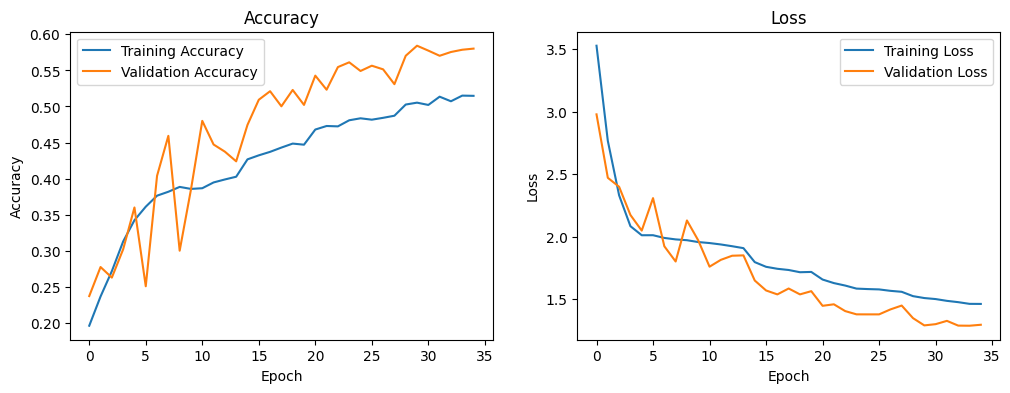

In [14]:
# prompt: make a code to plot history

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# prompt: generate the code to get the accuracy of the model on test data

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5233 - loss: 1.4181
Test Accuracy: 0.5817776322364807
Test Loss: 1.279655933380127


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


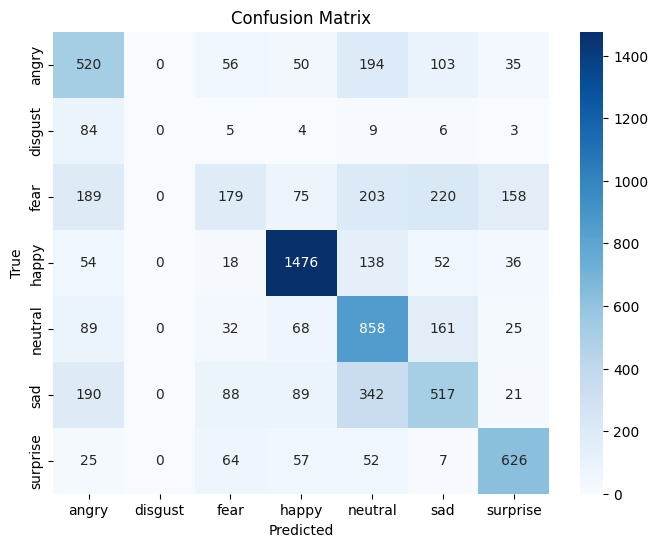

In [16]:
# prompt: generate a code to get the confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

# Get true labels
y_true = test_dataset.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.class_indices.keys(),  # Use class names as labels
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()